
### Data description

pclass: A proxy for socio-economic status (SES)
- 1st = Upper
- 2nd = Middle
- 3rd = Lower

age: Age is fractional if less than 1.
- If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
- Sibling = brother, sister, stepbrother, stepsister
- Spouse = husband, wife
>NOTE: number of siblings/spouses aboard

parch: The dataset defines family relations in this way...
- Parent = mother, father
- Child = daughter, son, stepdaughter, stepson
- Some children travelled only with a nanny, therefore parch=0 for them.
>NOTE: number of parents children aboard

### Tasks
Explore the data:
- make plots regarding each feature 
(e.g. scatter plots, histograms, box plots, heat map, etc.
minimum two types of plots for each feature
- decide which columns should be used for the prediction 
- calculate the correlation of each feature to the survival

hint: if a lot of values is missing than it sign to drop the whole column
- think about engineering your own features e.g. family size from sibsp & parch

In [1]:
import pandas as pd
import os

path = os.getcwd()
parent = os.path.dirname(path) # extract parent dir in cross platform way

path_to_plots = os.path.join(parent, "plots")
path_to_data = os.path.join(parent, "data")

In [11]:
train = pd.read_csv(os.path.join(path_to_data, "train.csv"))
test = pd.read_csv(os.path.join(path_to_data, "test.csv"))
gt = pd.read_csv(os.path.join(path_to_data, "gender_submission.csv"))
test = test.merge(gt, how="left", on="PassengerId")


In [12]:
# train.head()
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1


In [13]:
print(f"{train.isna().sum()}, {train.shape}, {test.isna().sum()}, {test.shape}")

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64, (891, 12), PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
Survived         0
dtype: int64, (418, 12)


In [14]:
# - remove cabin, almost all cabin entries are nan
# - remove ticket and name, are non informative for training
# - remove rows with nan
train_clean = train.drop(["PassengerId", "Cabin", "Ticket", "Name"], axis=1).dropna()
test_clean = test.drop(["PassengerId", "Cabin", "Ticket", "Name"], axis=1).dropna()

# change sex to numerical
gender_dict = {
    'male' : 0,
    'female' : 1
}
gender_df = pd.DataFrame.from_dict(gender_dict, orient='index', columns=["Gender"]).reset_index().rename({"index" : "Sex"}, axis=1)
train_clean = train_clean.merge(gender_df, how="left", on="Sex").drop("Sex", axis=1)
test_clean = test_clean.merge(gender_df, how="left", on="Sex").drop("Sex", axis=1)


train_oh = pd.get_dummies(train_clean["Embarked"])
train_clean = train_clean.join(train_oh).drop("Embarked", axis=1)
test_oh = pd.get_dummies(test_clean["Embarked"])
test_clean = test_clean.join(test_oh).drop("Embarked", axis=1)

train_clean.to_csv(os.path.join(path_to_data, "train_cleaned.csv"), index=False)
test_clean.to_csv(os.path.join(path_to_data, "test_cleaned.csv"), index=False)

print(train.shape, train_clean.shape, test.shape, test_clean.shape)

(891, 12) (712, 10) (418, 12) (331, 10)


In [15]:
test_clean.head()

,Pclass,Age,SibSp,Parch,Fare,Survived,Gender,C,Q,S
0,3,34.5,0,0,7.8292,0,0,0,1,0
1,3,47.0,1,0,7.0000,1,1,0,0,1
2,2,62.0,0,0,9.6875,0,0,0,1,0
3,3,27.0,0,0,8.6625,0,0,0,0,1
4,3,22.0,1,1,12.2875,1,1,0,0,1


In [16]:
train_clean.columns.tolist()

['Survived',
 'Pclass',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'Gender',
 'C',
 'Q',
 'S']

### Exploration

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

In [18]:
print(train_clean.corr(method='pearson', numeric_only=True)["Survived"])
# correlation with:
# - gender

Survived    1.000000
Pclass     -0.356462
Age        -0.082446
SibSp      -0.015523
Parch       0.095265
Fare        0.266100
Gender      0.536762
C           0.195673
Q          -0.048966
S          -0.159015
Name: Survived, dtype: float64

In [19]:
corr = train_clean.corr(numeric_only=True)
corr.style.background_gradient(cmap='coolwarm')

,Survived,Pclass,Age,SibSp,Parch,Fare,Gender,C,Q,S
Survived,1.000000,-0.356462,-0.082446,-0.015523,0.095265,0.266100,0.536762,0.195673,-0.048966,-0.159015
Pclass,-0.356462,1.000000,-0.365902,0.065187,0.023666,-0.552893,-0.150826,-0.279194,0.131989,0.197831
Age,-0.082446,-0.365902,1.000000,-0.307351,-0.187896,0.093143,-0.099037,0.038268,-0.021693,-0.025431
SibSp,-0.015523,0.065187,-0.307351,1.000000,0.383338,0.139860,0.106296,-0.046227,0.051331,0.018968
Parch,0.095265,0.023666,-0.187896,0.383338,1.000000,0.206624,0.249543,-0.009523,-0.009417,0.013259
Fare,0.266100,-0.552893,0.093143,0.139860,0.206624,1.000000,0.182457,0.301337,-0.062346,-0.250994
Gender,0.536762,-0.150826,-0.099037,0.106296,0.249543,0.182457,1.000000,0.103611,0.027256,-0.109078
C,0.195673,-0.279194,0.038268,-0.046227,-0.009523,0.301337,0.103611,1.000000,-0.095623,-0.884986
Q,-0.048966,0.131989,-0.021693,0.051331,-0.009417,-0.062346,0.027256,-0.095623,1.000000,-0.378859
S,-0.159015,0.197831,-0.025431,0.018968,0.013259,-0.250994,-0.109078,-0.884986,-0.378859,1.000000


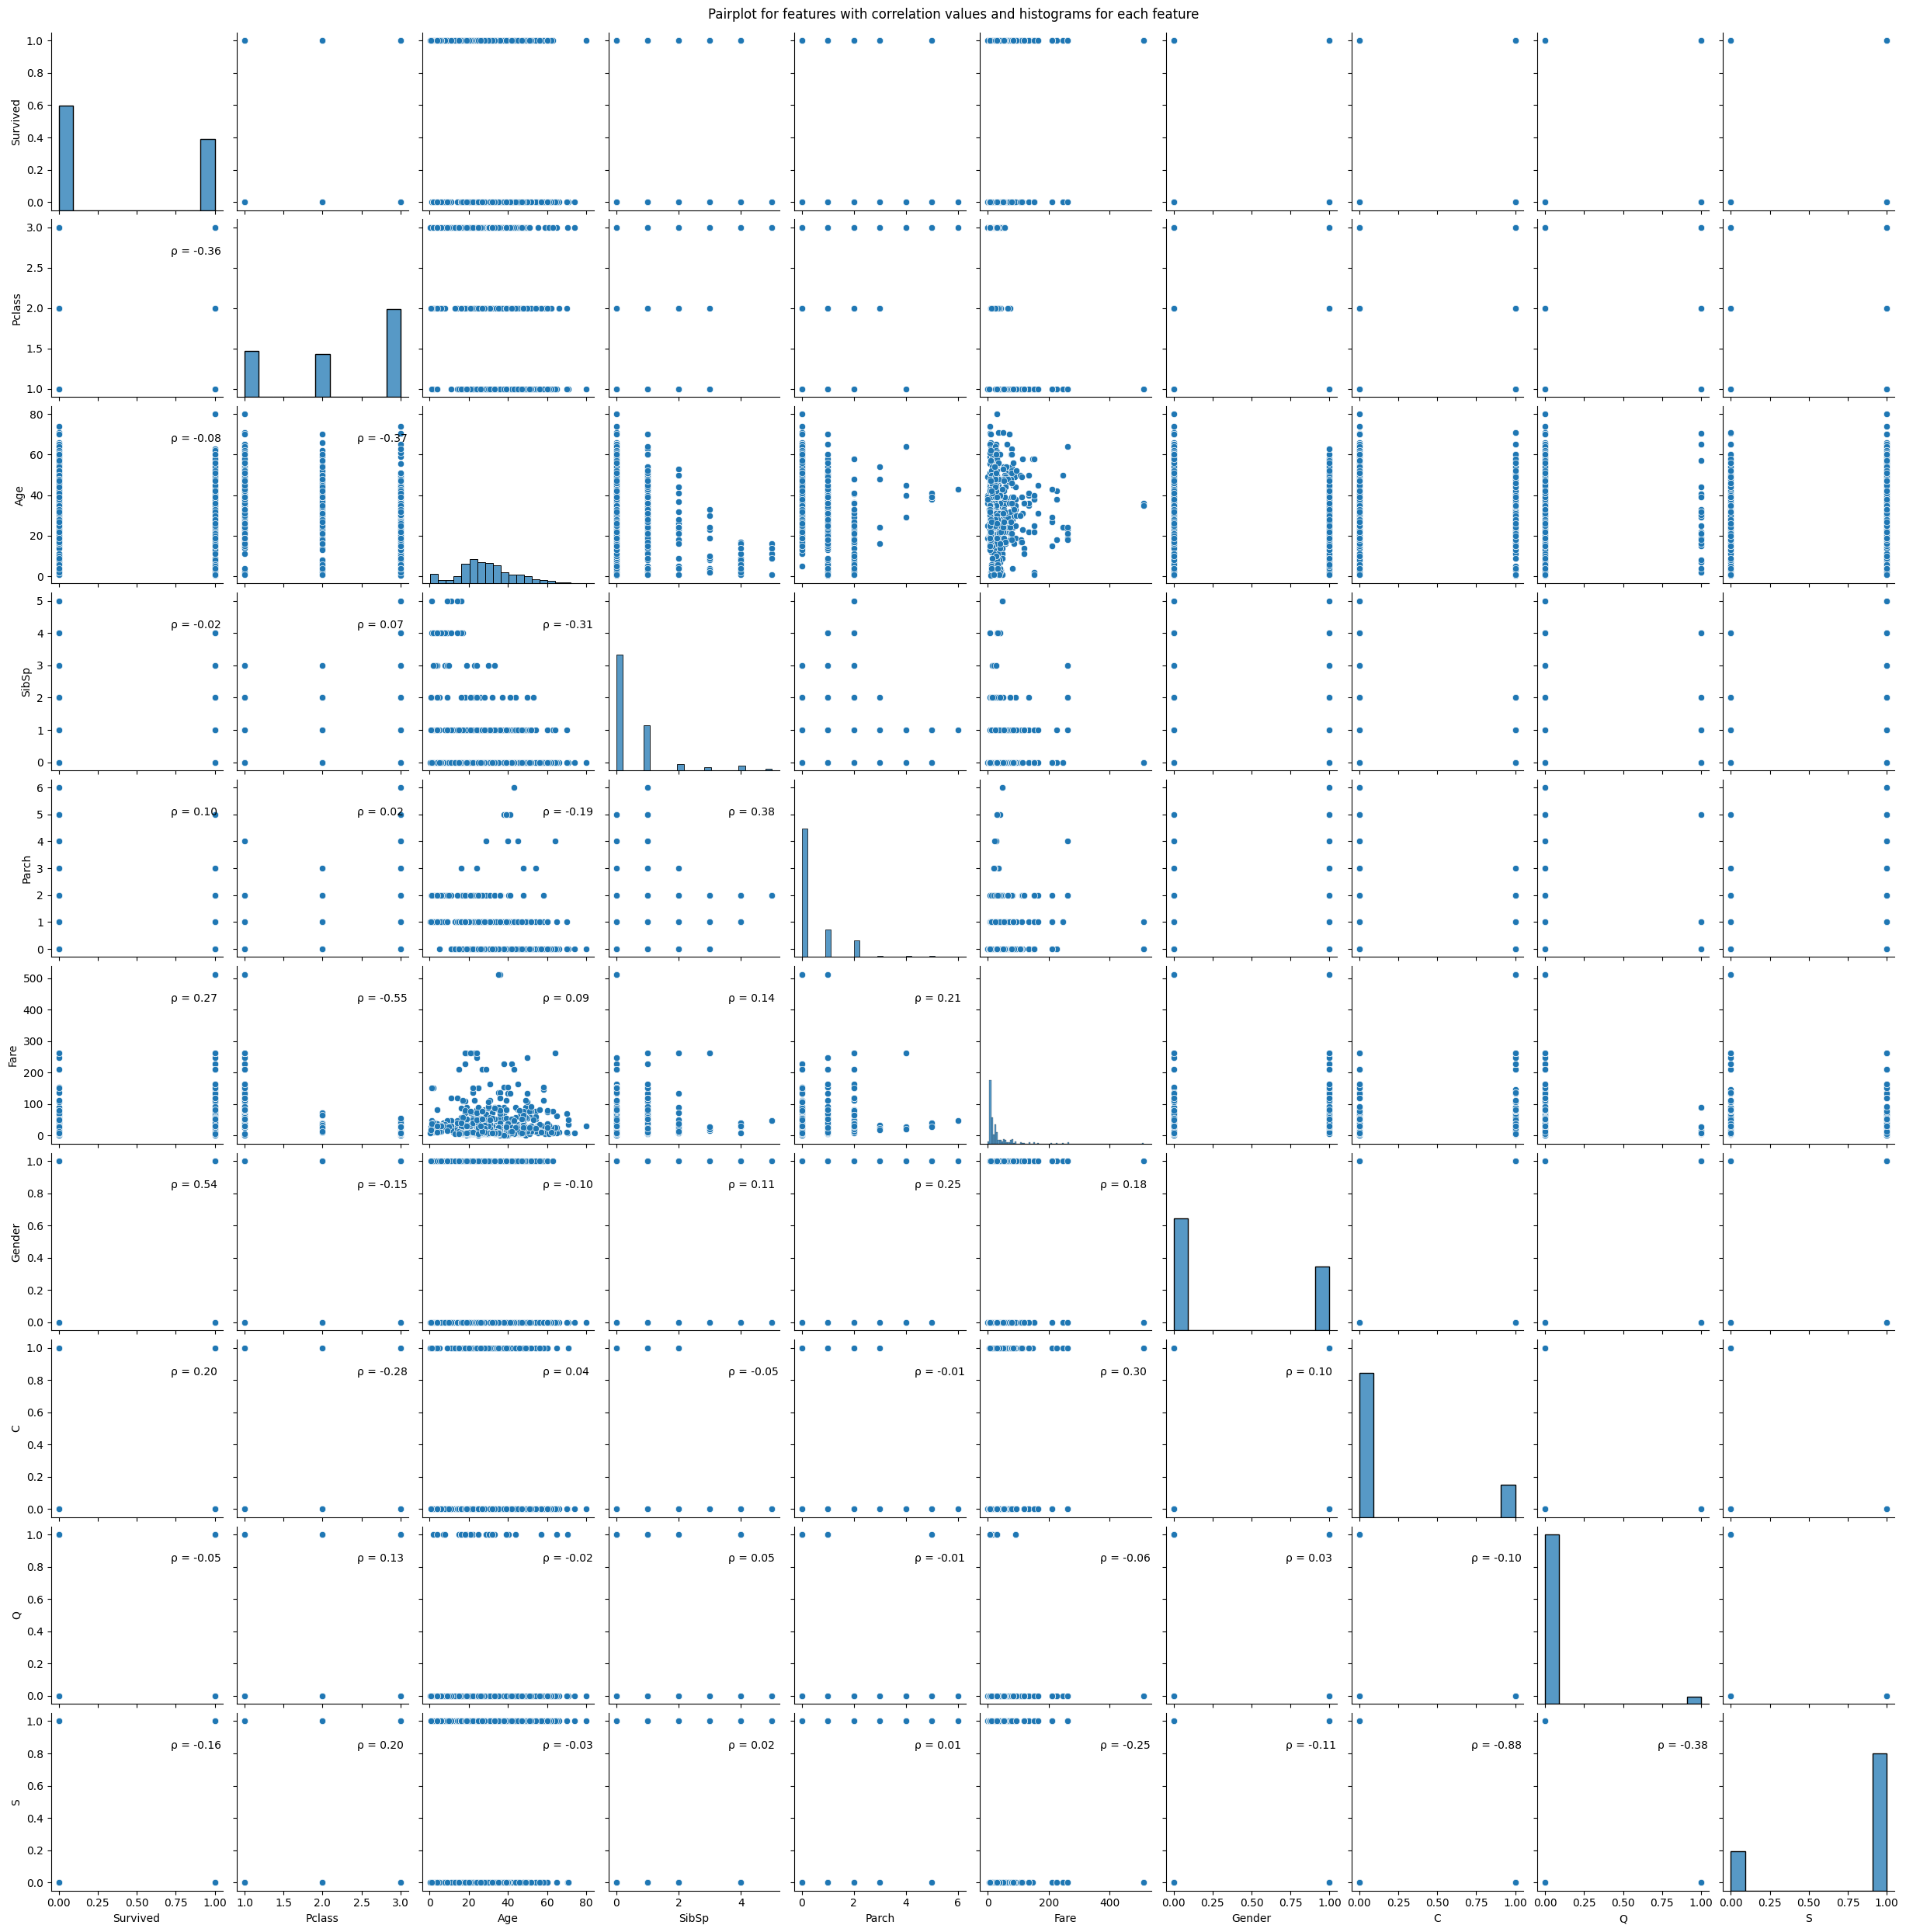

In [20]:

def corrfunc(x, y, ax=None, **kws):
    """Plot the correlation coefficient in the corner of a plot."""
    # https://stackoverflow.com/questions/50832204/show-correlation-values-in-pairplot
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.2f}', xy=(.7, .8), xycoords=ax.transAxes)

g = sns.pairplot(train_clean)
g.map_lower(corrfunc)
plt.suptitle("Pairplot for features with correlation values and histograms for each feature", x=0.5, y=1)
plt.show()
plt.savefig(os.path.join(path_to_plots, "corr_plot.png"))

In [21]:
train_clean.corr(method='pearson', numeric_only=True)["Pclass"]["Fare"]

-0.5528932206457601